# Import Libraries & Set up the Environment
The below code establishes the environment for a data analysis project involving geospatial data, sentiment analysis, and data visualization. It begins by importing a variety of libraries, including geospatial processing with geopandas, data manipulation with pandas, and sentiment analysis using VADER. It configures settings for the IPython shell to ensure comprehensive output display and maximum column visibility for data frames. The script defines the rt variable to specify the project's output directory path, facilitating file access. This setup enables efficient data analysis, sentiment scoring, and data visualization, making it a robust foundation for geospatial projects that involve sentiment analysis of large datasets.

In [2]:
import geopandas as gpd
import pandas as pd
import arcpy
import os
from pyproj import Transformer
import numpy as np
import math
import re
from datetime import datetime, timedelta
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_columns', None)
# the path to your local directory containing all project files
rt = r'path/to/your/project/output/directory'

# Write Functions for Cleaning Tweets  
The below code provided consists of two functions used to clean and modify text data. The first function, remove_pattern, takes two inputs: input_txt (a text string) and pattern (a regular expression pattern). It processes the input text by finding and removing patterns that match the given regular expression. The function returns the modified input_txt with the specified patterns removed. The second function, clean_tweets, takes a list or array of tweet texts as input. It uses the remove_pattern function to apply several cleaning operations to the tweet texts, such as removing Twitter return handles (e.g., "RT @xxx:"), Twitter handles (e.g., "@xxx"), URL links, and special characters, numbers, and punctuations (except for the '#' symbol). The function returns the same list of tweets with these cleaning operations applied.

In [3]:
def remove_pattern(input_txt, pattern):
    
    """
    This function is used to clean and modify text data by removing specific patterns based on the regular expression 

    INPUTS:
    input_txt: This is a text string that you want to process and remove certain patterns from.
    pattern: This is a regular expression pattern that defines what you want to find and remove from the input_txt.

    OUTPUTS: 
    the function returns the modified input_txt with the specified patterns removed
    """

    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)        
    return input_txt

def clean_tweets(tweets):
    
    """
    This function is used to clean and modify text data using several pattern removings

    INPUTS:
    tweets: This is a list or array of tweet texts that you want to clean.

    OUTPUTS: 
    the function returns the same list of tweets, but with several cleaning operations applied.
    """
    
    #remove twitter Return handles (RT @xxx:)
    tweets = np.vectorize(remove_pattern)(tweets, "RT @[\w]*:") 
    
    #remove twitter handles (@xxx)
    tweets = np.vectorize(remove_pattern)(tweets, "@[\w]*")
    
    #remove URL links (httpxxx)
    tweets = np.vectorize(remove_pattern)(tweets, "https?://[A-Za-z0-9./]*")
    
    #remove special characters, numbers, punctuations (except for #)
    tweets = np.core.defchararray.replace(tweets, "[^a-zA-Z]", " ")
    
    return tweets

# Step 1: Read & Preprocess The Collected Tweets
In this step, the scraped tweets using which was collected using TweetParser.py is read in a Pandas dataframe and duplicate records are removed. The reason for duplicates is that some of the buffer areas created to geographically collect the tweets from various US states had some minor overlap and those duplicated rows should be dropped prior to the analysis. 

In [4]:
#read data as a Pandas df 
COVID_df = pd.read_csv(rt + '\\CollectedTweets.csv')
#drop duplicated records
COVID_df = COVID_df.drop_duplicates()

# Step 2: Create a US States Geodataframe 
In this step, a GeoDataFrame for U.S. states is created by reading a shapefile and selecting specific fields such as state geometry, postal abbreviations, names, and land area. Additionally, U.S. region information is added to the GeoDataFrame by merging it with a crosswalk table, which associates states with their respective regions. The resulting GeoDataFrame, gdf_States, contains comprehensive geographical and regional data for U.S. states, facilitating further spatial analysis and mapping applications.

In [5]:
#reference: https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html
state_shp = r'path/to/your/census/states/boundaries/shapefile'
#reference: https://github.com/cphalpert/census-regions/blob/master/us%20census%20bureau%20regions%20and%20divisions.csv
usa_regions_cw = r'path/to/your/usa/state/regions/crosswalk/csv'

#list of fields to keep from states geodataframe
ST_fs = ['geometry','STUSPS','NAME','ALAND']

#read the states data shapefile as gdf
gdf_States = gpd.read_file(state_shp, crs = {'init': 'epsg:4326'}, usecols = ST_fs)[ST_fs]

#add US regions
df_USregionCW = pd.read_csv(usa_regions_cw)

#merge the above two dataframes to have a full set of state features with their region
gdf_States = pd.merge(gdf_States, df_USregionCW[['State','Region']], 
                      left_on='NAME', right_on = 'State', 
                      how='left').fillna('US Territory').drop('State', axis=1)

# Step 3: Clean the Tweets
In this step, the collected tweets are cleaned using the pattern removed functions.

In [6]:
%%time
#apply the pattern removed functions on the tweets
COVID_df['clean_tweets'] = clean_tweets(COVID_df['content'])
#show the top records
COVID_df['clean_tweets'].head()

Wall time: 1min 13s


0    Why does he still do daily covid announcements...
1    "Fauci Says Border Facilities Holding Migrant ...
2    In the classroom, teachers say things have got...
3      While  the governor of West Virginia has set...
4     And-yes, in regards to the entire Covid Circu...
Name: clean_tweets, dtype: object

# Step 4:  Calculate Polarity Score
I utilized VADER sentiment analysis to assess the polarity of COVID-related tweets. Vader is a useful method for quickly gauging public sentiment in social media data. It offers several advantages, including its simplicity, speed, and effectiveness in processing short, informal text. 

In [7]:
%%time
analyzer = SentimentIntensityAnalyzer()
scores = []
_ = [scores.append(analyzer.polarity_scores(row['clean_tweets'])['compound']) for _, row in COVID_df.iterrows()]
COVID_df['compound_polarity'] = scores
COVID_df.head(1)

Wall time: 5min 25s


,user,date,content,user_location,searched_location,clean_tweets,compound_polarity
0,"{'username': 'Rachael_wv', 'displayname': 'Rac...",2021-05-06 23:18:26+00:00,Why does he still do daily covid announcements...,West Virginia,WV,Why does he still do daily covid announcements...,-0.5514


# Step 5: Calculate Average Tweets Polarity of US States
In this step, the code calculates the average polarity of tweets for U.S. states, enabling a nationwide comparison during the Trump and Biden presidencies. The code starts by processing tweet data, differentiating tweets between the two presidents. It then aggregates sentiment scores (compound polarity) for the full period, Biden's term, and Trump's term, respectively. The resulting dataframes are merged, and initial analysis shows that average compound scores are close to neutral. Subsequent exploration focuses on negative and positive comments to gain further insights.

In [8]:
# create a date field
COVID_df['Datetime'] = pd.DatetimeIndex(pd.to_datetime(COVID_df['date'])).tz_localize(None)

#create a date to specify first day of Biden administration
BidenStartDate = pd.to_datetime('2021-01-20').tz_localize(None)

#now add a President column to specify which period does tweets belong to
COVID_df['President'] = np.where(COVID_df.Datetime >= BidenStartDate,'Biden','Trump')

#now calculate aggregated scores for Biden and Trump per searched location 
AggCols = ['searched_location','compound_polarity']
FullScore = COVID_df[AggCols].groupby('searched_location').mean().rename({'compound_polarity':'FullScore'}, axis = 1)
BidenScore = COVID_df.loc[COVID_df.President == 'Biden', AggCols].groupby(
    'searched_location').mean().rename({'compound_polarity':'BidenScore'}, axis = 1)
TrumpScore = COVID_df.loc[COVID_df.President == 'Trump', AggCols].groupby(
    'searched_location').mean().rename({'compound_polarity':'TrumpScore'}, axis = 1)

#merge the three score dfs  
dfaggs = [FullScore, BidenScore, TrumpScore]
dfaggs = reduce(lambda left, right: pd.merge(left, right, how = 'outer', left_index = True, right_index = True), dfaggs)
dfaggs.head(2)

,FullScore,BidenScore,TrumpScore
searched_location,,,
AK,0.016729,0.019691,0.009553
AL,0.061429,0.059752,0.062749


# Step 6: Analyze Negative and Positive Tweets
In this step, the code conducts an analysis of negative and positive sentiment scores separately for each president's term. It creates dataframes for negative (COVID_Neg) and positive (COVID_Pos) tweets based on polarity thresholds. The lengths of these dataframes indicate substantial counts of both negative and positive tweets, with negative tweets totaling approximately 441k and positive tweets about 537k. The code then generates a count plot illustrating the number of negative pandemic-related tweets for each state during the Trump and Biden administrations. The plot highlights that states with larger cities, such as New York and California, exhibit significantly higher tweet counts. Most states show slightly more negative comments for Trump, although the difference in counts is generally minor.

441322

537610

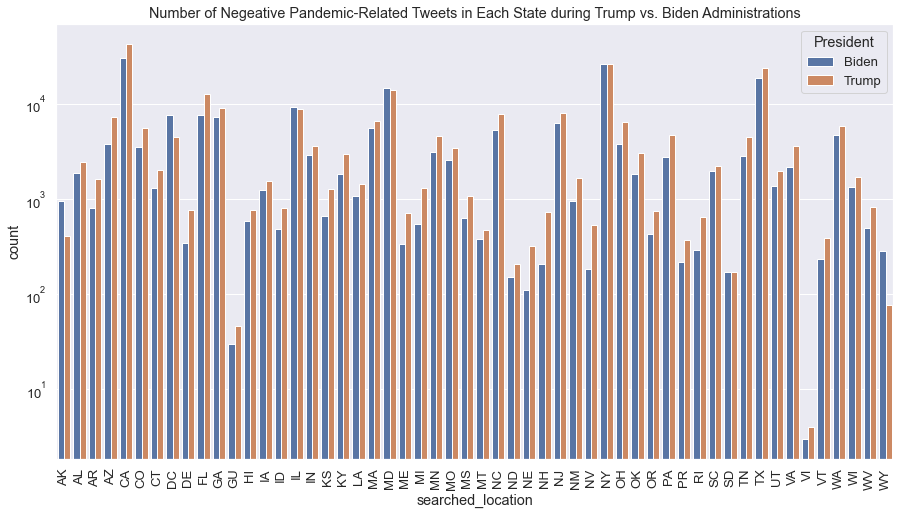

In [9]:
#seperate negative and positive tweets based on the compound polarity score
COVID_Neg = COVID_df[COVID_df.compound_polarity <= -0.05].sort_values(['searched_location','President'])
COVID_Pos = COVID_df[COVID_df.compound_polarity >= 0.05].sort_values(['searched_location','President'])

#check the total number of negative and positive tweets
len(COVID_Neg)
len(COVID_Pos)

#plot counts of negative tweets per state for each administration 
sns.set(font_scale = 1.2)
fig = plt.figure(figsize = (15,8))
#creat an axis to plot
ax1 = fig.add_subplot(111)
_ = plt.xticks(rotation = 90)
ax = sns.countplot(x = "searched_location", hue='President', ax = ax1, data = COVID_Neg)
_ = ax1.set_yscale('log')
_ = ax.set_title('Number of Negative Pandemic-Related Tweets in Each State during Trump vs. Biden Administrations')

# Step 7: Analyze Compound Score of Negative Tweets
In this step, the code analyzes the compound scores of negative pandemic-related tweets for each state during the Trump and Biden administrations. It creates a bar plot illustrating the compound polarity scores with states on the x-axis and scores on the y-axis, color-coded by the President. The plot indicates that, in most states, the compound scores for negative tweets are higher for Trump than for Biden. However, there are exceptions in states like Wyoming (WY), Hawaii (HI), Guam (GU), and South Dakota (SD). The code suggests that mapping the change in negative scores of tweets during the transition from the Trump to Biden administration would be a valuable analysis. 

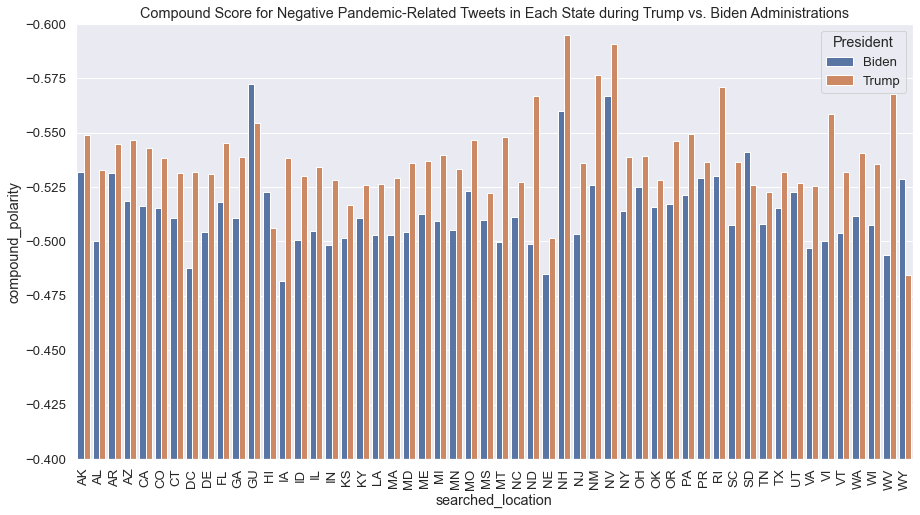

In [10]:
#plot counts of negative tweets per state for each administration
sns.set(font_scale = 1.2)
fig = plt.figure(figsize = (15,8))
ax1 = fig.add_subplot(111)
_ = plt.xticks(rotation = 90)
_ = plt.ylim(-0.4, -0.6)
ax = sns.barplot(x = "searched_location",y = 'compound_polarity',hue = 'President', 
                 ax = ax1, data = COVID_Neg, ci = None)
_ = ax.set_title('Compound Score for Negative Pandemic-Related Tweets in Each State during Trump vs. Biden Administrations')

# Step 8: Analyze Change in Polarity of Negative and Positive Tweets Between Administrations
In this step, the code calculates and maps the change in average negative and positive scores of tweets during the transition from the Trump to Biden administration. It computes the change in polarity of negative and positive tweets and adds this information to the states' geospatial data frame (gdf_States). The analysis indicates that the change in average negativity appears more significant than the change in positivity following the Biden administration, based on the summary of the PosScoreChange_COVID data.

In [231]:
#calculate change in polarity of negative tweets
grp_neg = COVID_Neg.groupby(['searched_location','President'], as_index = False).mean().groupby(
    'searched_location', as_index = False)
NegScoreChange_COVID = pd.DataFrame(data = {
    'State':grp_neg.groups.keys(), 'NegScoreChange_COVID':-1*grp_neg.compound_polarity.diff().dropna().compound_polarity})

#now add this to the states geodataframe
gdf_States = pd.merge(gdf_States, NegScoreChange_COVID, left_on = 'STUSPS',
                      right_on = 'State', how='left').drop('State', axis = 1)
gdf_States.head(1)
gdf_States.NegScoreChange_COVID.describe()

#calculate change in polarity of positive tweets
grp_pos = COVID_Pos.groupby(['searched_location','President'],as_index = False).mean().groupby(
    'searched_location',as_index=False)
PosScoreChange_COVID = pd.DataFrame(data={
    'State':grp_pos.groups.keys(),'PosScoreChange_COVID':-1*grp_pos.compound_polarity.diff().dropna().compound_polarity})

#now add this to the states geodataframe
gdf_States = pd.merge(gdf_States, PosScoreChange_COVID,left_on='STUSPS',right_on = 'State',how='left').drop('State',axis = 1)
gdf_States.head(1)
gdf_States.PosScoreChange_COVID.describe()

,geometry,STUSPS,NAME,ALAND,Region,NegScoreChange_COVID
0,"POLYGON ((-81.74725 39.09538, -81.74635 39.096...",WV,West Virginia,62266231560,South,0.073916


count    54.000000
mean      0.024586
std       0.019684
min      -0.044165
25%       0.016034
50%       0.026986
75%       0.029967
max       0.073916
Name: NegScoreChange_COVID, dtype: float64

,geometry,STUSPS,NAME,ALAND,Region,NegScoreChange_COVID,PosScoreChange_COVID
0,"POLYGON ((-81.74725 39.09538, -81.74635 39.096...",WV,West Virginia,62266231560,South,0.073916,0.006173


count    54.000000
mean     -0.000661
std       0.046536
min      -0.087287
25%      -0.010771
50%      -0.004523
75%       0.005285
max       0.298337
Name: PosScoreChange_COVID, dtype: float64

# Step 9: Calculate Counts of Negative and Positive Tweets 
In this step, the code adds the counts of negative and positive tweets related to COVID-19 for both the Trump and Biden administrations to the states' geospatial data frame (gdf_States). It calculates the counts of negative and positive tweets separately and assigns them to the respective columns in the geospatial data frame, providing insights into the volume of COVID-19-related tweets during each administration at the state level.

In [232]:
######Trump's Negative COVID-related Tweet Counts ######
TrumpNegTweetCount = COVID_Neg[COVID_Neg.President == 'Trump'].groupby(
    'searched_location',as_index = False).count()[['searched_location','user']].rename(
    columns = {'user':'TrumpNegTweetCount_COVID'})
#now add this to the states geodataframe
gdf_States = pd.merge(gdf_States, TrumpNegTweetCount, left_on = 'STUSPS', right_on = 'searched_location', how='left').drop(
    'searched_location',axis = 1)

######Biden's Negative COVID-related Tweet Counts ######
BidenNegTweetCount = COVID_Neg[COVID_Neg.President == 'Biden'].groupby(
    'searched_location', as_index=False).count()[['searched_location','user']].rename(
    columns = {'user':'BidenNegTweetCount_COVID'})
#now add this to the states geodataframe
gdf_States = pd.merge(gdf_States, BidenNegTweetCount, left_on = 'STUSPS', right_on = 'searched_location', how = 'left').drop(
    'searched_location',axis = 1)

######Trump Pos COVID Tweet Counts ######
TrumpPosTweetCount = COVID_Pos[COVID_Pos.President == 'Trump'].groupby(
    'searched_location',as_index = False).count()[['searched_location','user']].rename(
    columns = {'user':'TrumpPosTweetCount_COVID'})
#now add this to the states geodataframe
gdf_States = pd.merge(gdf_States, TrumpPosTweetCount,left_on = 'STUSPS', right_on = 'searched_location',how = 'left').drop(
    'searched_location', axis = 1)

######Biden Pos COVID Tweet Counts ######
BidenPosTweetCount = COVID_Pos[COVID_Pos.President == 'Biden'].groupby(
    'searched_location',as_index = False).count()[['searched_location','user']].rename(
    columns = {'user':'BidenPosTweetCount_COVID'})
#now add this to the states geodataframe
gdf_States = pd.merge(gdf_States,BidenPosTweetCount, left_on = 'STUSPS', right_on = 'searched_location', how = 'left').drop(
    'searched_location', axis = 1)

gdf_States.head(1)

,geometry,STUSPS,NAME,ALAND,Region,NegScoreChange_COVID,PosScoreChange_COVID,TrumpNegTweetCount_COVID,BidenNegTweetCount_COVID,TrumpPosTweetCount_COVID,BidenPosTweetCount_COVID
0,"POLYGON ((-81.74725 39.09538, -81.74635 39.096...",WV,West Virginia,62266231560,South,0.073916,0.006173,814.0,494.0,743.0,696.0


# Step 10: Find Representative Negative and Positive Tweets 
In this step, the code finds representative tweets for positive and negative sentiments related to COVID-19 for each state during both the Trump and Biden administrations. It makes sure that these tweets do not contain inappropriate language. The code selects examples of negative and positive tweets based on sentiment scores and the absence of certain words. These tweets are then merged with the state's geospatial data frame, allowing for the analysis of sentiment at the state level during each administration. The sentiment analysis is conducted separately for Trump and Biden to provide insights into the tone of tweets for both administrations.

In [234]:
##### Trump Negative Tweet Examples for each State 
cond1 = (COVID_Neg.President == 'Trump') & (COVID_Neg.clean_tweets.str.len() > 10) & (
    ~COVID_Neg.clean_tweets.str.lower().str.contains('fuck'))
idxNeg_T = COVID_Neg[cond1].reset_index().groupby('searched_location').apply(lambda x: x.compound_polarity.idxmin())
dfNegTweet_T = COVID_Neg[cond1].reset_index().iloc[idxNeg_T.values, :][['clean_tweets', 'searched_location']].rename(
    columns={"clean_tweets": 'TrumpNegTweet_COVID"})
# merge this with the state geodataframe
gdf_States = pd.merge(gdf_States, dfNegTweet_T, left_on='STUSPS', right_on='searched_location', how='left').drop(
    'searched_location', axis=1)

##### Biden Negative Tweet Examples for each State 
cond1 = (COVID_Neg.President == 'Biden') & (COVID_Neg.clean_tweets.str.len() > 10) & (
    ~COVID_Neg.clean_tweets.str.lower().str.contains('fuck'))
idxNeg_B = COVID_Neg[cond1].reset_index().groupby('searched_location').apply(lambda x: x.compound_polarity.idxmin())
dfNegTweet_B = COVID_Neg[cond1].reset_index().iloc[idxNeg_B.values, :][['clean_tweets', 'searched_location']].rename(
    columns={"clean_tweets": 'BidenNegTweet_COVID"})
# merge this with the state geodataframe
gdf_States = pd.merge(gdf_States, dfNegTweet_B, left_on='STUSPS', right_on='searched_location', how='left').drop(
    'searched_location', axis=1)

##### Trump Positive Tweet Examples for each State 
cond1 = (COVID_Pos.President == 'Trump') & (COVID_Pos.clean_tweets.str.len() > 10) & (
    ~COVID_Pos.clean_tweets.str.lower().str.contains('fuck'))
idxPos_T = COVID_Pos[cond1].reset_index().groupby('searched_location').apply(lambda x: x.compound_polarity.idxmax())
dfPosTweet_T = COVID_Pos[cond1].reset_index().iloc[idxPos_T.values, :][['clean_tweets', 'searched_location']].rename(
    columns={"clean_tweets": 'TrumpPosTweet_COVID"})
# merge this with the state geodataframe
gdf_States = pd.merge(gdf_States, dfPosTweet_T, left_on='STUSPS', right_on='searched_location', how='left').drop(
    'searched_location', axis=1)

##### Biden Positive Tweet Examples for each State 
cond1 = (COVID_Pos.President == 'Biden') & (COVID_Pos.clean_tweets.str.len() > 10) & (
    ~COVID_Pos.clean_tweets.str.lower().str.contains('fuck'))
idxPos_B = COVID_Pos[cond1].reset_index().groupby('searched_location').apply(lambda x: x.compound_polarity.idxmax())
dfPosTweet_B = COVID_Pos[cond1].reset_index().iloc[idxPos_B.values, :][['clean_tweets', 'searched_location']].rename(
    columns={"clean_tweets": 'BidenPosTweet_COVID"})
# merge this with the state geodataframe
gdf_States = pd.merge(gdf_States, dfPosTweet_B, left_on='STUSPS', right_on='searched_location', how='left').drop(
    'searched_location', axis=1)

gdf_States.head(1)

,geometry,STUSPS,NAME,ALAND,Region,NegScoreChange_COVID,PosScoreChange_COVID,TrumpNegTweetCount_COVID,BidenNegTweetCount_COVID,TrumpPosTweetCount_COVID,BidenPosTweetCount_COVID,TrumpNegTweet_COVID,BidenNegTweet_COVID,TrumpPosTweet_COVID,BidenPosTweet_COVID
0,"POLYGON ((-81.74725 39.09538, -81.74635 39.096...",WV,West Virginia,62266231560,South,0.073916,0.006173,814.0,494.0,743.0,696.0,I am so disappointed and disparaged that natio...,I hate Trump for his covid response and the he...,Thanksgiving looked a little different this ye...,Well my mama tested positive for covid on Wedn...
